# **Cloud Security Exp - 4**
## **Phishing Website Detection using Cloud-hosted Data Mining**

## **Install all the required Libraries**

In [9]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [10]:
# import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# upload the datasets

# from google.colab import files
# files.upload()

In [12]:
import os

In [19]:
phishing_path = "phishing-urls.csv"
legit_path = "legitimate-urls.csv"

def load_csv(path):
  if not os.path.exists(path):
    raise FileNotFoundError(f"{path} not found")

  df = pd.read_csv(path, dtype=str, low_memory=False, on_bad_lines='skip')
  return df

phishing = load_csv(phishing_path)
legit = load_csv(legit_path)

In [21]:
phishing.head()

,url,Type
0,https://docs.google.com/presentation/d/e/2PACX...,Phishing
1,https://btttelecommunniccatiion.weeblysite.com/,Phishing
2,https://kq0hgp.webwave.dev/,Phishing
3,https://brittishtele1bt-69836.getresponsesite....,Phishing
4,https://bt-internet-105056.weeblysite.com/,Phishing


In [22]:
legit.head()

,url,type
0,https://www.google.com,legitimate
1,https://www.youtube.com,legitimate
2,https://www.facebook.com,legitimate
3,https://www.baidu.com,legitimate
4,https://www.wikipedia.org,legitimate


In [24]:
# check the url column

def find_url_col(df):
  candidates = [c for c in df.columns if c.lower() in ('url','link','website','website_url','uri','domain','site')]

  if candidates:
    return candidates[0]

  for c in df.columns:
    sample = df[c].dropna().astype(str).head(200).str.lower()
    if sample.str.contains('http').sum() > 5 or sample.str.contains('www').sum > 5:
      return c

  return df.columns[0]

In [27]:
# consistently rename the url-col to url
phishing = phishing.rename(columns={find_url_col(phishing):'url'})[['url']].dropna().reset_index(drop=True)
legit = legit.rename(columns={find_url_col(legit):'url'})[['url']].dropna().reset_index(drop=True)

# assign labels for classification
phishing['label']=1
legit['label']=0

# concat the dataframes phishing and legit together
data = pd.concat([phishing, legit], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
data

,url,label
0,http://start-settings.000webhostapp.com/recove...,0
1,https://www.musicboxtheband.com/,0
2,http://vvps.ws/44/mothersdarlingcross.php?,0
3,https://www.majesticvanguard.net/site.php,0
4,https://www.city-data.com/el-paso-properties/a...,0
...,...,...
534715,https://www.hfboards.com/showthread.php?t=681077,0
534716,https://www.docstoc.com/docs/40190420/KARST-AQ...,0
534717,https://www.reunion.com/oh/lima/lima+senior+hi...,0
534718,https://www.flightwise.com/airport/SKF.html,0


## **Feature Engineering**

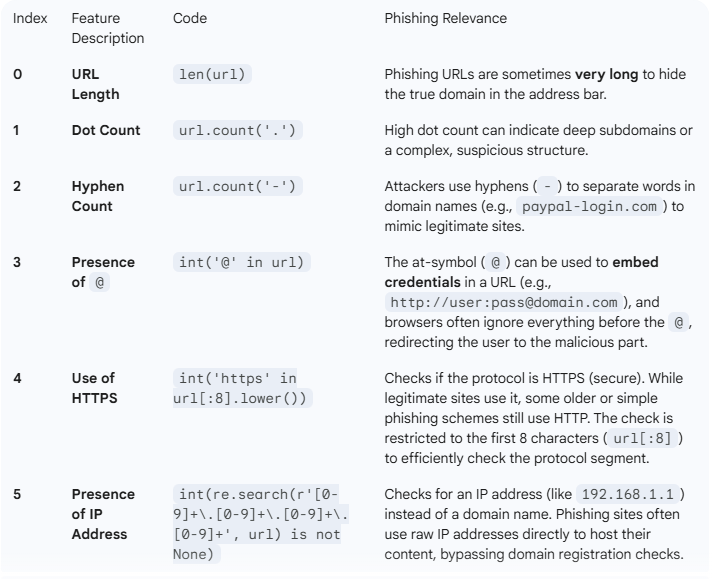

**Note**: int(condition) converts the boolean result of a check (True or False) into an integer ($1$ or $0$).

In [31]:
# extract lexical features from the URLs (characteristics based on the text string)
# Lexical features are often used in URL classification (like distinguishing phishing from legitimate sites) because attackers frequently use specific string patterns to confuse users or evade detection.

import re

def extract_features(url):
  return [
      len(url),
      url.count('.'),
      url.count('-'),
      int('@' in url),
      int('https' in url[:8].lower()),
      int(re.search(r'[0-9]+\.[0-9]+\.[0-9]+\[0-9]+', url) is not None)
  ]

# feature reshaping
X = data['url'].apply(extract_features)
X = pd.DataFrame(X.tolist(), columns=['length','dots','hyphens','has_at','has_https','has_ip'])
y = data['label']

## **Train Test split**

In [32]:
!pip install scikit-learn

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [34]:
X_train

,length,dots,hyphens,has_at,has_https,has_ip
99739,44,2,0,0,1,0
528109,43,2,0,0,1,0
10497,76,3,7,0,1,0
477092,39,2,0,0,0,0
97447,26,1,0,0,0,0
...,...,...,...,...,...,...
180436,54,3,0,0,1,0
453279,92,1,1,0,1,0
215661,36,2,0,0,0,0
264762,36,2,0,0,1,0


In [35]:
y_train

,label
99739,0
528109,0
10497,0
477092,1
97447,0
...,...
180436,0
453279,1
215661,0
264762,0


## **Model Training - Decision Tree**

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## **Model Training - Random Forest**

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## **Model Evaluation**

In [38]:
from sklearn.metrics import classification_report, accuracy_score

for name, model in [("Decision Tree", dt), ("Random Forest", rf)]:
  y_pred = model.predict(X_test)
  print("Accuracy: ", accuracy_score(y_test, y_pred))
  print("Classification Report: ", classification_report(y_test, y_pred))

Accuracy:  0.9294023040095751
Classification Report:                precision    recall  f1-score   support

           0       0.94      0.99      0.96    143974
           1       0.82      0.40      0.54     16442

    accuracy                           0.93    160416
   macro avg       0.88      0.69      0.75    160416
weighted avg       0.92      0.93      0.92    160416

Accuracy:  0.9296391881109116
Classification Report:                precision    recall  f1-score   support

           0       0.94      0.99      0.96    143974
           1       0.82      0.40      0.54     16442

    accuracy                           0.93    160416
   macro avg       0.88      0.70      0.75    160416
weighted avg       0.92      0.93      0.92    160416



## **Save/Load Model**

In [39]:
!pip install joblib

In [41]:
import joblib

joblib.dump(rf, "phishing_rf_model.pkl")
model = joblib.load("phishing_rf_model.pkl")

## **Test with sample URLs**

In [46]:
test_urls = [
    "http://secure.paypal.com.fake-site/login",
    "https://www.google.com",
    "https://rvce.edu.in"
]

test_features = pd.DataFrame([extract_features(u) for u in test_urls])
y_pred = rf.predict(test_features)
print(list(zip(test_urls, y_pred)))

[('http://secure.paypal.com.fake-site/login', np.int64(0)), ('https://www.google.com', np.int64(0)), ('https://rvce.edu.in', np.int64(0))]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


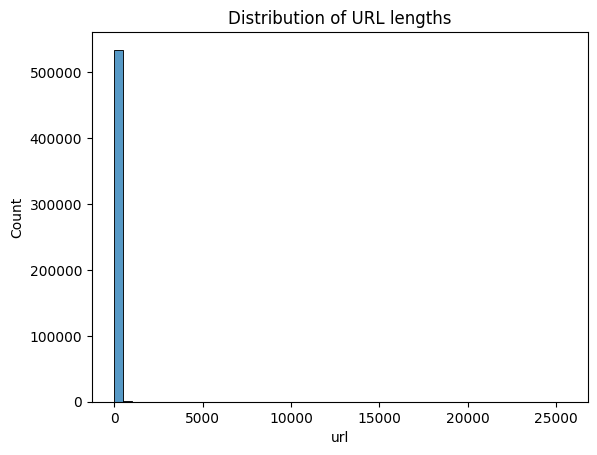

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['url'].apply(len), bins=50)
plt.title("Distribution of URL lengths")
plt.show()